### Adaptive Instance Normalization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.utils import save_image

from PIL import Image
from IPython.display import Image as display_image
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

#### <b>인코더 및 디코더 네트워크</b>

* <b>인코더(Encoder)</b>: VGG 형식의 네트워크를 사용하여 이미지로부터 특징(feature)을 추출(extract)합니다.
* <b>디코더(Decoder)</b>: 인코더와 유사한 네트워크이지만 <b>반대로 해상도(너비 X 높이)를 키우는 방식으로 동작</b>합니다.

#### <b>인코더(Encoder)</b>

* VGG 네트워크에서 맥스 풀링(max pooling)을 총 4번 진행하지만, Style Transfer에서는 ReLU4_1까지만 사용합니다.
    * 따라서 사실상 다운샘플링(downsampling)은 3번까지만 진행된다고 이해할 수 있습니다.

In [3]:
# 인코더(Encoder) 정의
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(), # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

#### <b>디코더(Decoder)</b>

* 디코더는 인코더 네트워크를 반대로 뒤집은 것과 유사한 구조를 가집니다.
* 인코더 파트에서 3번의 다운샘플링(downsampling)을 거치므로, 디코더에서는 3번의 업샘플링(upsampling)을 거칩니다.

In [4]:
# 디코더(Decoder) 정의
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

In [5]:
# 사전 학습된(Pre-trained) 모델 불러오기
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth

--2021-08-19 06:42:47--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FYnM2WEVTMzdvdExnV1c1Y2F2Q1k5WUJ5R09uWEpENXdDMFdaZ1FQcDh2QUpnP3J0aW1lPW5uOFFqOXhpMlVn [following]
--2021-08-19 06:42:48--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9

In [6]:
# get trained model
decoder.eval() # https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31]) # ReLU4_1까지만 사용

In [7]:
def calc_mean_std(feat, eps=1e-5): # AdaIN
    ''' 이미지의 각 채널 평균(mean)과 표준편차(std) 값을 계산 '''
    size = feat.size()
    assert (len(size) == 4) # Feature Map의 형태: (N: 배치 크기, C: 채널 크기, H: 높이, W: 너비)
    N, C = size[:2]  # 한 번에 하나의 이미지만 넣을 것이므로 N은 1
    feat_var = feat.view(N, C, -1).var(dim=2) + eps # 입실론(epsilon)은 0으로 나누는 것을 예방하기 위한 작은 상수
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

In [8]:
def adaptive_instance_normalization(content_feat, style_feat): # style_transfer
    ''' content image에 style 적용'''
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    # 평균(mean)과 표준편차(std)를 이용하여 정규화 수행
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    # 정규화 이후에 style feature의 statistics를 가지도록 설정
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

In [9]:
def style_transfer(vgg, decoder, content, style, alpha=1.0): # main
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

In [10]:
def test_transform(size=512): # main
    ''' 이미지 전처리 '''
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform
content_tf = test_transform()
style_tf = test_transform()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


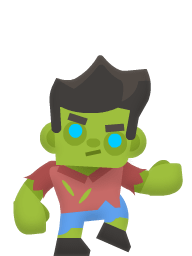

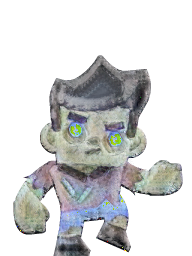

In [11]:
# # main
# ⚠️ 디렉터리 내 이미지 전체에 스타일 변이 코드 추가 필요

content_path = '/content/drive/MyDrive/데이터 팀/mount_drive/Darkest-Cave/Data/Content_Images/Zombie/character_zombie_attack0.png'
style_path = '/content/drive/MyDrive/데이터 팀/mount_drive/Darkest-Cave/Data/Style_Images/horror/horror37.jpg'

# alpha channel, original_size 정의
origin_content_image = Image.open(str(content_path)).convert("RGBA") 
alpha_content = np.array(origin_content_image)[:,:, 3]
x, y, _ = np.array(origin_content_image).shape

# 이미지 전처리
content_image = origin_content_image.convert("RGB")
content = content_tf(content_image)
style = style_tf(Image.open(str(style_path)))
content = content.to(device).unsqueeze(0)
style = style.to(device).unsqueeze(0)

# 이미지 변환 
with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=1.0) # ✅ alpha : content 비율
output = output.cpu()

# 이미지 크기 원래대로 
tf = transforms.ToPILImage()
output_PIL = tf(output[0])
output_array = np.array(output_PIL)
output_resized = cv2.resize(output_array, (y, x))

# alpha channel 값 추가
output_final = cv2.cvtColor(output_resized, cv2.COLOR_RGB2RGBA)
output_final[:,:, 3] = alpha_content

cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/data/model_test/output.png', output_final)
cv2_imshow(np.array(origin_content_image))
cv2_imshow(output_final)